# Lab 2: Image processing

The goal of this lab is to practice applying the image processing algorithms that you have learnt in lectures. You will be implementing functions to modify the brightness and contrast of an image, as well as apply gamma correction. Finally, you will also implement a simple alpha composition function to blend two images together.

In [1]:
import numpy as np
import  cv2

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from typing import Callable

In [2]:
def displayImage(img: np.array, window_name: str = "Display window")-> None:
    '''
        Display an image in a numpy array using cv2.
        Note: cv2 assumes images to be stored in HxWxC and BGR format
        if the images are in float, they are assumed to be in 0-1
        range.


        :param img: Image to display stored in a numpy array
        :param window_name: Name to display on the window
    '''

    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)
    cv2.imshow(window_name, img)
    # Wait for a key event infinitely
    cv2.waitKey(0)

    # Close all open windows
    cv2.destroyAllWindows()
    # For mac users, uncomment the following line
    cv2.waitKey(1)

In [3]:
def printImages(imgs: list[np.array], grid: tuple[int], figsize: tuple[int]=(20, 20))->None:
    '''
        Print images to the notebook in a grid using matplotlib
        Note: matplotlib assumes images to be shared in HxWxC and RGB format.
        Grayscale images are assumed to be in 0-1 range

        :param imgs: list of Images to be printed stored in a numpy array
        :param grid: dimensions of the grid to print the images
    '''

    fig = plt.figure(figsize=(grid[0]*figsize[0], grid[1]*figsize[1]))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=grid,  # creates a grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.imshow(im, cmap='gray', vmin=0, vmax=1)

In [4]:
image = cv2.imread('./input_image.jpg', cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

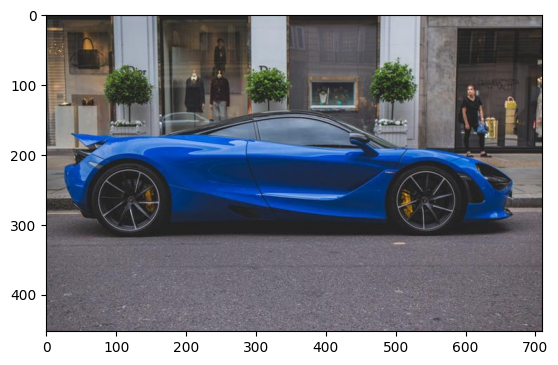

In [5]:
plt.imshow(image)

# Local point operators / image processing transforms

Implement a function to change the brightness of an image given an offset value.

In [6]:
def modify_brightness(image: np.array, offset: int)->np.array:
    '''
    Given an input image, compute a new image where the brightness is changed by an offset (or bias)

    :param image: an image stored in a numpy array
    :param offset: value to change the brightness of the image by
    '''
    modified_image = image.astype(np.uint16) # convert to unsigned 16 bits to be able to multifly.
    brighter_image = modified_image + offset
    modified_image = np.clip(brighter_image, 0, 255) # cliping to make the min value is 0 and the max value is 255 
    modified_image = modified_image.astype(np.uint8) # convert into  unsigned int 8 to not have a problem when it is used to visualize

    return modified_image

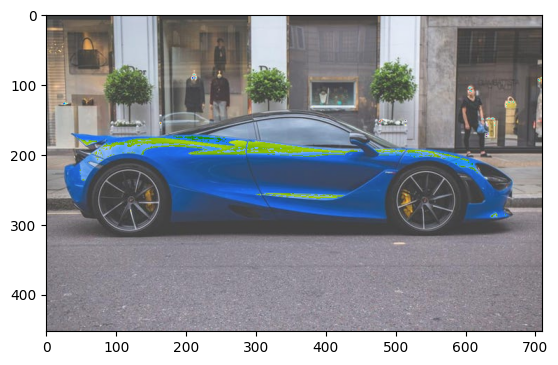

In [7]:
brightened_image = modify_brightness(image, offset=32)
plt.imshow(brightened_image)

Implement a function to change the contrast of an image given a gain value.

In [8]:
def modify_contrast(image: np.array, gain: float)->np.array:
    '''
    Given an input image, compute a new image where the contrast is changed by the gain

    :param image: an image stored in a numpy array
    :param gain: value to change the contrast of the image by
    '''
    modified_image = image.astype(np.uint16) # convert to unsigned 16 bits to be able to multifly.
    contrast_image = modified_image * gain # multifly with the gaine to change the contrast
    modified_image = np.clip(contrast_image, 0, 255)
    modified_image = modified_image.astype(np.uint8) # convert into  unsigned int 8 to not have a problem when it is used to visualize

    return modified_image

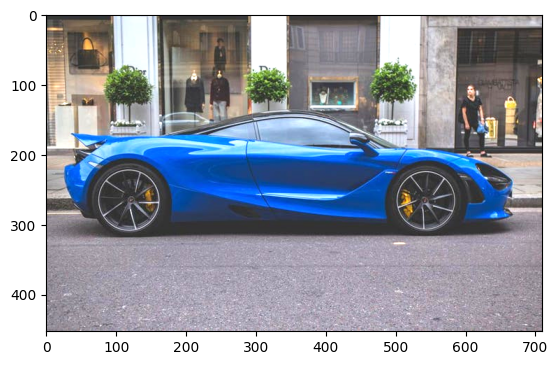

In [9]:
contrasted_image = modify_contrast(image, gain=1.5)
plt.imshow(contrasted_image)

Implement a function to apply gamma correction to an image.

In [32]:
def gamma_correct(image: np.array, gamma: float)->np.array:
    '''
    Given an input image, compute a new image by applying gamma correction

    :param image: an image stored in a numpy array
    :param gamma: gamma correction value
    '''
    # 
    normalized_image = image / 255.0  # 0~255 → 0~1
    gamma_correction = normalized_image ** (1.0 / gamma)
    modified_image = np.clip(gamma_correction * 255.0 , 0, 255)
    modified_image = modified_image.astype(np.uint8) # convert into  unsigned int 8 to not have a problem when it is used to visualize

    return modified_image

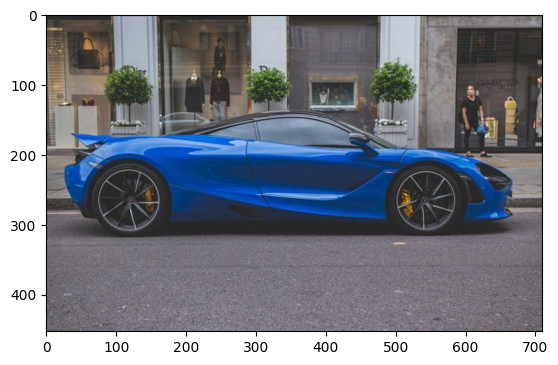

In [33]:
gamma_corrected_image = gamma_correct(image, gamma=1.1)
plt.imshow(gamma_corrected_image)

# Compute image matting and composition

In this part, you are given a source image, mask and background image. The goal is to extract the object outlined by the mask from the source image and composite it onto the background image.

In [34]:
source_image = cv2.imread('./source_image.png', cv2.IMREAD_UNCHANGED)
mask = cv2.imread('./mask.png', cv2.IMREAD_UNCHANGED)
background_image = cv2.imread('./background_image.jpg', cv2.IMREAD_UNCHANGED)
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

In [39]:
print(mask)
print(mask.shape)


[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(282, 400, 3)
(282, 400, 3)


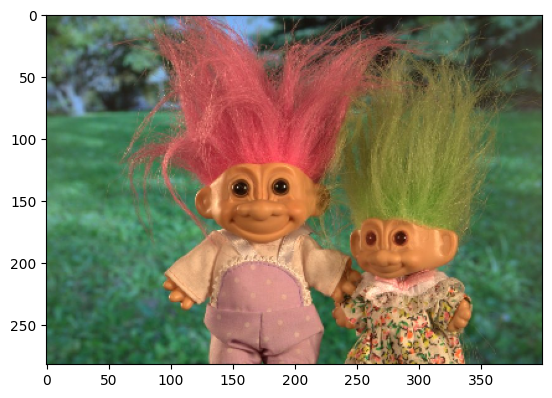

In [61]:
plt.imshow(source_image)

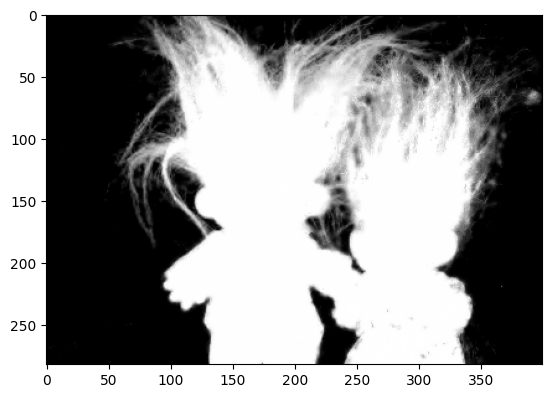

In [36]:
plt.imshow(mask)

Write a function to extract the foreground object from the source image.

In [65]:
def extract_foreground(image: np.array, mask: np.array, threshold: int)->np.array:
    '''
    Given an input image and a binary mask, compute a new image by extracting the foreground object

    :param image: an image stored in a numpy array
    :param mask: binary mask stored in a numpy array
    '''
    # np.where(condition, 0 (replace this pixel by 0), 1 )

    binary_mask = np.where(mask < threshold, 0, 1)
    modified_image = image * binary_mask
    # convery the mask to binary mask then multiply to extract


    return modified_image

In [66]:
foreground = extract_foreground(source_image, mask, threshold=200)

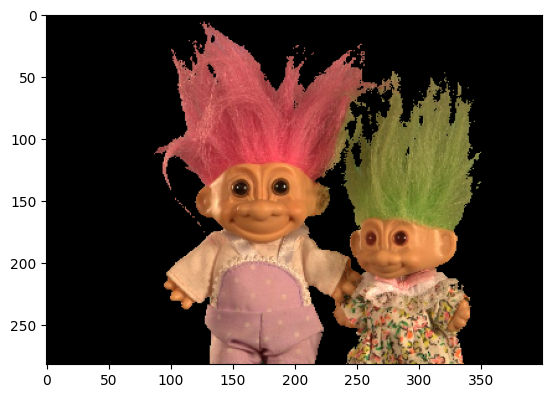

In [67]:
plt.imshow(foreground)

Write a function to composite the extracted object onto the background image.

In [84]:
def composite(foreground_image: np.array, background_image: np.array, alpha: float, mask: np.array)->np.array:
    '''
    Given the foreground and background images, compute a new image by compositing the foreground object onto the background

    :param foreground_image: an image stored in a numpy array that shows the foreground object
    :param background_image: an image stored in a numpy array that shows the desired background
    :param alpha: value for alpha composition
    '''
    # C = aF + (1-a)B
    normalized_mask = mask / 255.0
    modified_image = normalized_mask *  (alpha * foreground_image) +  (1 - normalized_mask)  * background_image
    modified_image = np.clip(modified_image, 0, 255)
    modified_image = modified_image.astype(np.uint8)

    return modified_image

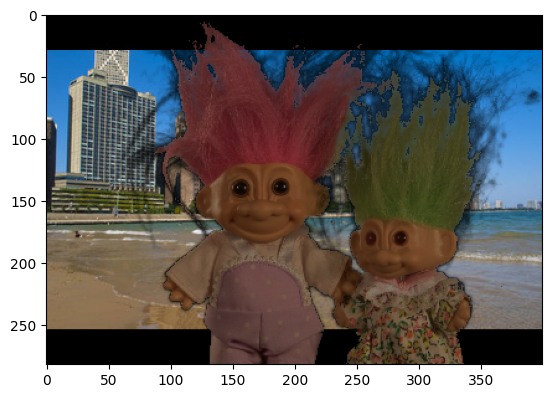

In [85]:
alpha = 0.5
final_image = composite(foreground, background_image, alpha, mask)
plt.imshow(final_image)